In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/Object Detection

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Object Detection


In [2]:
import json
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image, ImageDraw
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision import transforms
import time
import torch.backends.cudnn as cudnn
import torch.utils.data
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import utils #local
import transforms as T #local

# General Data Preprocessing

In [3]:
badges_df = pd.read_csv('via_region_data-13.csv')

## Cleaning up the csv file imported from www.robots.ox.ac.uk 
(To be used only once: new csv saved to memory)


https://www.robots.ox.ac.uk/~vgg/software/via/via-1.0.6.html

In [5]:
badges_df['region_attributes'] = badges_df['region_attributes'].replace(to_replace='{"badgeColor":"blue"}', value='blue')
badges_df['region_attributes'] = badges_df['region_attributes'].replace(to_replace='{"badgeColor":"orange"}', value='orange')

In [6]:
# Removing most of the unnecessary symbols from the dataframe
badges_df = badges_df.replace('{', '', regex=True)
badges_df = badges_df.replace('}', '', regex=True)
badges_df.region_shape_attributes = badges_df.region_shape_attributes.replace('"', '', regex=True)
badges_df.region_shape_attributes = badges_df.region_shape_attributes.replace('name:', '', regex=True)
badges_df.region_shape_attributes = badges_df.region_shape_attributes.replace('rect,', '', regex=True)

In [7]:
# Expanding the coordinates from a single string to 4 columns and adding them to the dataframe
coordinates = badges_df.region_shape_attributes.str.split(',', expand=True)
coordinates.columns = ['x', 'y', 'width', 'height']
# Also getting rid of the last extra labels in the data, leaving just the numbers
badges_df['x'] = coordinates['x'].replace('x:', '', regex=True)
badges_df['y'] = coordinates['y'].replace('y:', '', regex=True)
badges_df['width'] = coordinates['width'].replace('width:', '', regex=True)
badges_df['height'] = coordinates['height'].replace('height:', '', regex=True)

In [8]:
# Removing the rows with 'None' values.
badges_df = badges_df.dropna()

# Reseting the index column, since some rows have been eliminated
badges_df = badges_df.reset_index(drop=True)

In [9]:
# Pytorch uses the coordinate system of (x,y,x,y), so to avoid having to perform addition every time data is accessed, it is done here, once
def add(a,b):
  return int(a)+int(b)

badges_df['x1'] = badges_df.apply(lambda row : add(row['x'],
                     row['width']), axis = 1)
badges_df['y1'] = badges_df.apply(lambda row : add(row['y'],
                     row['height']), axis = 1)

In [10]:
badges_df['x'] = badges_df.apply(lambda column : int(column['x']), axis = 1)
badges_df['y'] = badges_df.apply(lambda column : int(column['y']), axis = 1)

In [11]:
# Getting rid of the columns we don't need
badges_df = badges_df.drop(columns='file_attributes')
badges_df = badges_df.drop(columns='region_id')
badges_df = badges_df.drop(columns='file_size')
badges_df = badges_df.drop(columns='region_shape_attributes')
badges_df = badges_df.drop(columns='width')
badges_df = badges_df.drop(columns='height')

In [12]:
# Renaming the remaining columns 
badges_df = badges_df.rename(columns={"#filename": "filename", 'region_count':'count', 'region_attributes':'color'})

In [16]:
badges_df = badges_df.drop(columns='color')

### Saving to storage

In [18]:
badges_df.to_csv('test_dataset.csv')

## Data Visualization

In [17]:
badges_df

,filename,num persons,x,y,x1,y1
0,cropped_image1.jpg,1,41,2,82,48
1,cropped_image2.jpg,1,44,3,84,51
2,cropped_image3.jpg,1,41,0,90,49
3,cropped_image4.jpg,1,37,2,80,42
4,cropped_image5.jpg,1,35,1,84,46
5,cropped_image6.jpg,1,37,5,90,49
6,cropped_image7.jpg,1,38,5,93,43
7,cropped_image8.jpg,1,37,6,85,48
8,cropped_image9.jpg,1,27,1,92,49
9,cropped_image10.jpg,1,31,2,85,54


In [87]:
# Check how balanced the collected data is
badges_df['color'].value_counts()

blue      57
orange    23
Name: color, dtype: int64

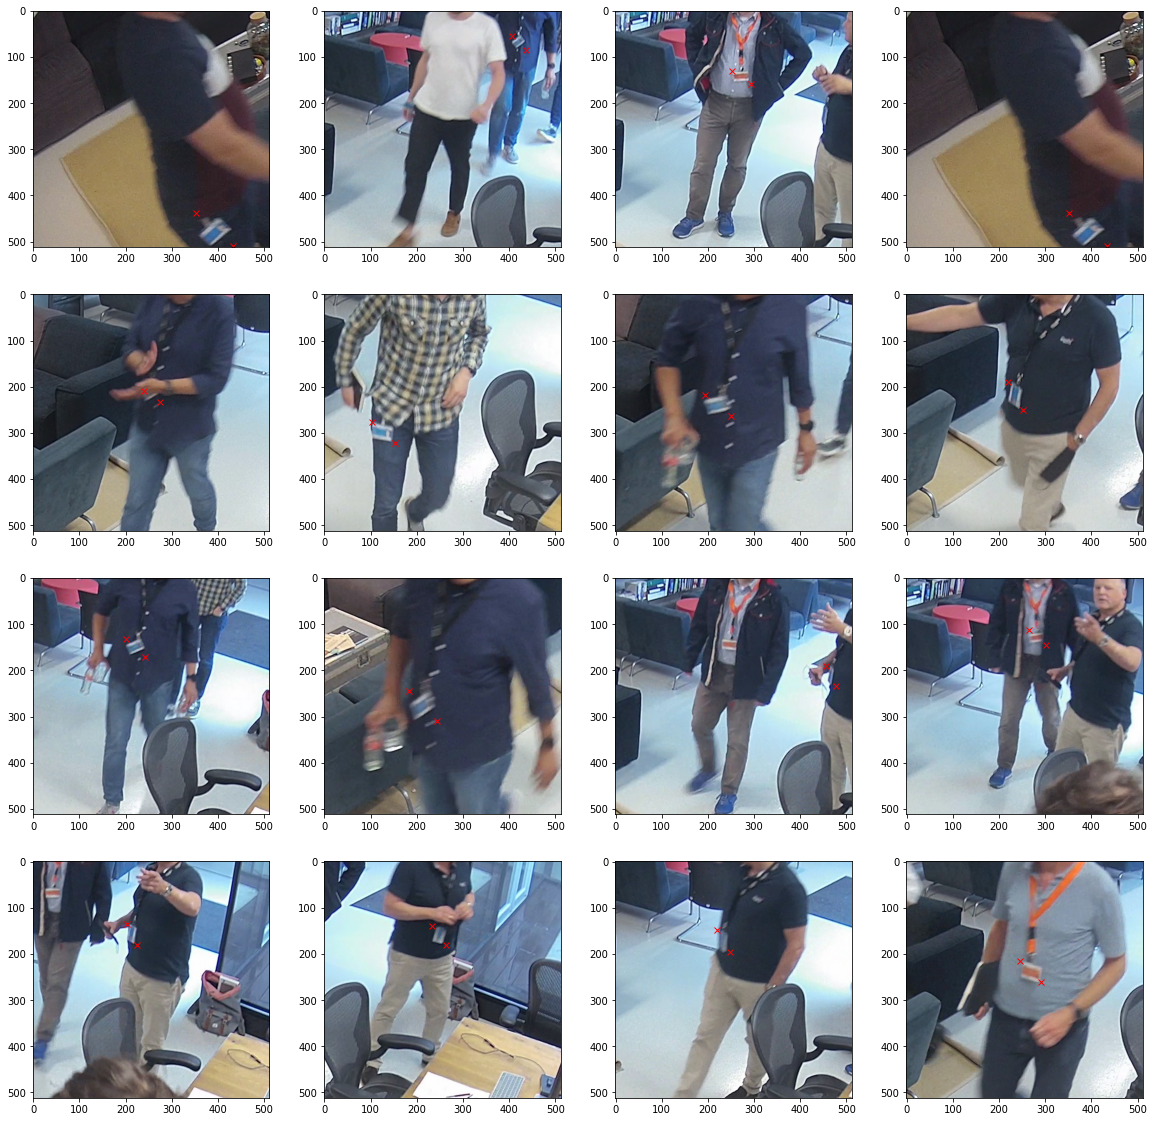

In [12]:
# Visualise some data
import random
# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    k = random.randint(1, len(badges_df))
    ax = fig.add_subplot(4, 4, i + 1)
    p = os.path.join('dataset', badges_df['filename'][k]) 
    image = plt.imshow(mpimg.imread(p))
    
    plt.plot(badges_df.loc[k][3], badges_df.loc[k][4], 'rx')
    plt.plot(badges_df.loc[k][5], badges_df.loc[k][6], 'rx')

# Building/Selecting the Model

In [3]:
# This is a function so that the model can be easily loaded later (when loading from memory)
def get_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [5]:
def get_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [6]:
model = get_model(num_classes = 2) # 2 classes: background and badges

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth


# Data Prep for Model Training Input

### Download TorchVision repo to use some files from references/detection

In [24]:
# Only necessary to do once
'''
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../
'''

'\n%%shell\n\ngit clone https://github.com/pytorch/vision.git\ncd vision\ngit checkout v0.3.0\n\ncp references/detection/utils.py ../\ncp references/detection/transforms.py ../\ncp references/detection/coco_eval.py ../\ncp references/detection/engine.py ../\ncp references/detection/coco_utils.py ../\n'

### Defining the main Dataset class

In [7]:
# Adapting the general pyTorch Dataset class
class BadgesDataset(Dataset):
    """Badges dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.badges_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.badges_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        boxes=[]
        img_name = os.path.join(self.root_dir, str(self.badges_df.iloc[idx, 1]))
        image = plt.imread(img_name)
        box = self.badges_df.iloc[idx, 4:]
        boxes.append(box)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((1,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        #Commented out target classes unnecessary to our application
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target["masks"] = masks
        target["image_id"] = image_id
        #target["area"] = area
        #target["iscrowd"] = iscrowd

        if self.transform is not None:
            image, target = self.transform(image, target)

        return image, target

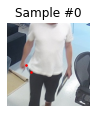

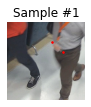

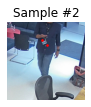

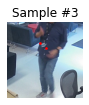

In [8]:
# Little demo to ensure everything's working as expected

badges_dataset = BadgesDataset(csv_file='badges_df.csv', root_dir='dataset/')

def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[0,0], landmarks[0,1], s=10, marker='.', c='r')
    plt.scatter(landmarks[0,2], landmarks[0,3], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

fig = plt.figure()

for i in range(len(badges_dataset)):
    image, target = badges_dataset[i]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(image, target['boxes'])

    if i == 3:
        plt.show()
        break

### Defining the Dataset and Dataloader

In [9]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [10]:
badges_dataset = BadgesDataset(csv_file='badges_df.csv', root_dir='dataset/', transform=get_transform(train=True))

In [11]:
dataloader = torch.utils.data.DataLoader(badges_dataset, batch_size=4,
                        shuffle=True, num_workers=2, collate_fn=utils.collate_fn)

In [12]:
badges_dataset_test = BadgesDataset(csv_file='badges_df_test.csv', root_dir='dataset/', transform=get_transform(train=False))

In [13]:
dataloader_test = torch.utils.data.DataLoader(badges_dataset_test, batch_size=1,
                        shuffle=False, num_workers=2, collate_fn=utils.collate_fn)

# Training

In [34]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

num_epochs = 10

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq=10)

  # update the learning rate
  lr_scheduler.step()

  #evaluate on the test dataset
  #evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/20]  eta: 0:00:08  lr: 0.000268  loss: 0.4702 (0.4702)  loss_classifier: 0.1474 (0.1474)  loss_box_reg: 0.3168 (0.3168)  loss_objectness: 0.0042 (0.0042)  loss_rpn_box_reg: 0.0018 (0.0018)  time: 0.4113  data: 0.2143  max mem: 579
Epoch: [0]  [10/20]  eta: 0:00:01  lr: 0.002897  loss: 0.4702 (0.5128)  loss_classifier: 0.1786 (0.1883)  loss_box_reg: 0.2689 (0.3120)  loss_objectness: 0.0072 (0.0095)  loss_rpn_box_reg: 0.0023 (0.0030)  time: 0.1733  data: 0.0326  max mem: 579
Epoch: [0]  [19/20]  eta: 0:00:00  lr: 0.005000  loss: 0.4778 (0.5723)  loss_classifier: 0.1876 (0.2280)  loss_box_reg: 0.3168 (0.3307)  loss_objectness: 0.0075 (0.0104)  loss_rpn_box_reg: 0.0024 (0.0031)  time: 0.1532  data: 0.0235  max mem: 579
Epoch: [0] Total time: 0:00:03 (0.1552 s / it)
Epoch: [1]  [ 0/20]  eta: 0:00:07  lr: 0.005000  loss: 0.7782 (0.7782)  loss_classifier: 0.2226 (0.2226)  loss_box_reg: 0.5140 (0.5140)  loss_objectness: 0.0322 (0.0322)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 

In [41]:
version = input("Input the version (preferred format: vNumber): ")
torch.save(model.state_dict(), os.path.join("trainedModel", version))

Input the version (preferred format: vNumber): v4


# Testing the model / Inference

In [42]:
#load the model from memory
model = get_model(num_classes = 2)
model.load_state_dict(torch.load("trainedModel/v4"))

<All keys matched successfully>

### For visualising the results after giving the model a dataset

[{'boxes': tensor([[267.9438, 164.9964, 307.7487, 198.0645],
        [265.9803, 159.1588, 300.1369, 185.9944]]), 'labels': tensor([1, 1]), 'scores': tensor([0.7789, 0.2565])}]


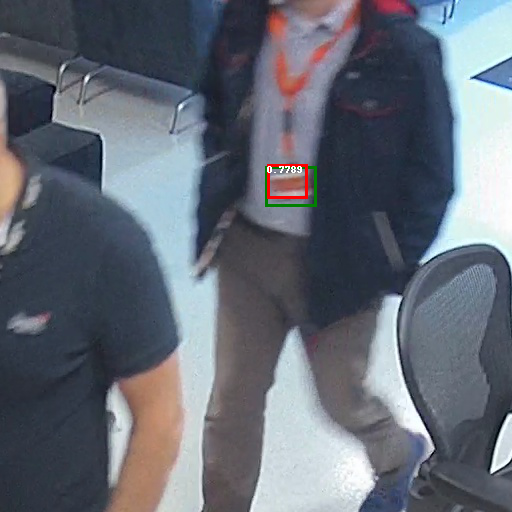

In [43]:
#Testing the model on a dataset
idx = 0
img, _ = badges_dataset_test[idx]
label_boxes = np.array(badges_dataset_test[idx][1]["boxes"])

model.eval()
with torch.no_grad():
    prediction = model([img])
    print(prediction)
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)
# Ground truth (green box)
for elem in range(len(label_boxes)):
    draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
    (label_boxes[elem][2], label_boxes[elem][3])], outline ="green", width =3)
# Prediction (red box)
for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(), decimals= 4)
    if score > 0.7:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = str(score))
image

### For testing *any* image

In [31]:
#loads an image and returns a tensor
#(automatically scales to required input size, therefore any image can be passed forward to the model)
loader = transforms.Compose([transforms.Scale(300), transforms.ToTensor()])
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    return image

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


[{'boxes': tensor([[ 53.1252, 235.9805,  84.3670, 260.3344],
        [  8.2395, 399.0657,  38.8722, 490.2011]]), 'labels': tensor([1, 1]), 'scores': tensor([0.8233, 0.0525])}]


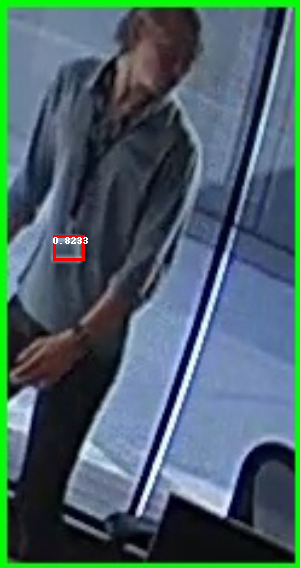

In [44]:
image = image_loader('cropped_image2.jpg')

model.eval()
with torch.no_grad():
    prediction = model([image])
    print(prediction)
image = Image.fromarray(image.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)
for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(), decimals= 4)
    if score > 0.4:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = str(score))
image